# ML Covariance Estimation for Portfolio Allocation
## CAC 40 constituents (data via `yfinance`)

### What you will learn
1. Why the **sample covariance** can be fragile for portfolio allocation.
2. How **regularization / ML structure** (shrinkage, factor models, sparsity) can improve stability.
3. How to evaluate covariance estimators through **out-of-sample portfolio behavior**.

### Rules of the game
- Use **daily log returns**.
- Use rolling windows (e.g., 252 trading days) to estimate covariance.
- Compare estimators using:
  - realized volatility (out-of-sample)
  - turnover
  - concentration (Herfindahl index)

> This notebook contains guided **TODOs**. Fill them in and run cells in order.


# Ledoit–Wolf shrinkage covariance

Let $X\in\mathbb{R}^{T\times N}$ be centered returns (each column demeaned). The sample covariance is
$$
S=\frac{1}{T-1}X^\top X .
$$

Ledoit–Wolf shrinkage estimates covariance as a convex combination of $S$ and a structured target $F$:
$$
\widehat{\Sigma}_{\mathrm{LW}}=(1-\delta)\,S+\delta\,F,\qquad \delta\in[0,1].
$$

A common target is the scaled identity (“constant variance, zero correlation”):
$$
F=\mu I,\qquad \mu=\frac{1}{N}\operatorname{tr}(S).
$$

---

## Graphical Lasso (sparse precision)

Let $S$ be the sample covariance and $\Theta=\Sigma^{-1}$ the precision matrix. Graphical Lasso solves:
$$
\widehat{\Theta}
=\arg\min_{\Theta\succ 0}\;
\Bigl\{\operatorname{tr}(S\Theta)-\log\det(\Theta)+\lambda\|\Theta\|_{1}\Bigr\},
$$
where $\|\Theta\|_{1}=\sum_{i,j}|\Theta_{ij}|$ and $\lambda\ge 0$ controls sparsity.

Then the covariance estimate is
$$
\widehat{\Sigma}_{\mathrm{GL}}=\widehat{\Theta}^{-1}.
$$

(Variant that penalizes only off-diagonal entries:)
$$
\|\Theta\|_{1,\mathrm{off}}=\sum_{i\ne j}|\Theta_{ij}|.
$$


## OAS (Oracle Approximating Shrinkage)

OAS is a shrinkage covariance estimator of the same form as Ledoit–Wolf:
$$
\widehat{\Sigma}_{\mathrm{OAS}}=(1-\delta_{\mathrm{OAS}})\,S+\delta_{\mathrm{OAS}}\,F,
$$
where $S$ is the sample covariance and the target is typically the scaled identity
$$
F=\mu I,\qquad \mu=\frac{1}{N}\operatorname{tr}(S).
$$
---

## PCA / Factor covariance estimator

Assume a $K$-factor model for returns $r_t\in\mathbb{R}^N$:
$$
r_t = B f_t + \varepsilon_t,
$$
with factor loadings $B\in\mathbb{R}^{N\times K}$, factors $f_t\in\mathbb{R}^K$, and idiosyncratic noise $\varepsilon_t$.

If $\Sigma_f=\operatorname{Cov}(f_t)$ and $\Psi=\operatorname{Cov}(\varepsilon_t)$ (often diagonal), then
$$
\Sigma \approx B\Sigma_f B^\top + \Psi.
$$

A PCA-based implementation uses the top $K$ principal components: let $U_K\in\mathbb{R}^{N\times K}$ be the top $K$ eigenvectors of $S$ and $\Lambda_K\in\mathbb{R}^{K\times K}$ the corresponding eigenvalues (diagonal). Then a common “factor + diagonal” estimate is
$$
\widehat{\Sigma}_{\mathrm{PCA}} = U_K \Lambda_K U_K^\top + \widehat{\Psi},
$$
with idiosyncratic variances set to match the sample variances:
$$
\widehat{\Psi}=\operatorname{diag}\!\Bigl(S - U_K \Lambda_K U_K^\top\Bigr).
$$

In [7]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.linalg import eigvalsh
from scipy.optimize import minimize

from sklearn.covariance import LedoitWolf, OAS, GraphicalLasso
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.set_printoptions(precision=4, suppress=True)

## 1) Load CAC 40 constituent prices and compute returns

Yahoo Finance tickers for Euronext Paris typically end with `.PA`. We download adjusted close prices and compute log returns.

**Task:** Run the cell. Check the number of assets after cleaning.


In [8]:
import yfinance as yf

CAC40_INDEX = '^FCHI'  # optional benchmark

# CAC 40 constituents (static list for teaching; may differ from today's composition)
TICKERS = [
    'AC.PA','AI.PA','AIR.PA','MT.AS','CS.PA','BNP.PA','EN.PA','BVI.PA','CAP.PA','CA.PA',
    'ACA.PA','BN.PA','DSY.PA','FGR.PA','ENGI.PA','EL.PA','ERF.PA','ENX.PA','RMS.PA','KER.PA',
    'OR.PA','LR.PA','MC.PA','ML.PA','ORA.PA','RI.PA','PUB.PA','RNO.PA','SAF.PA','SGOB.PA',
    'SAN.PA','SU.PA','GLE.PA','STLAP.PA','STMPA.PA','HO.PA','TTE.PA','URW.PA','VIE.PA','DG.PA'
]

START = '2016-01-01'
END = None

px = yf.download(
    tickers=TICKERS,
    start=START,
    end=END,
    interval='1d',
    auto_adjust=True,
    progress=False,
    group_by='column',
    threads=True,
)

close = px['Close'] if isinstance(px.columns, pd.MultiIndex) else px[['Close']]
close = close.dropna(how='all').ffill()

# Keep assets with at least 90% data coverage
min_frac = 0.90
keep = close.notna().mean().sort_values(ascending=False)
keep = keep[keep >= min_frac].index
close = close[keep].dropna()

rets = np.log(close).diff().dropna()

print('Universe size after cleaning:', rets.shape[1])
print('Date range:', rets.index.min().date(), '→', rets.index.max().date())
rets.head()



1 Failed download:
['SGOB.PA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2016-01-01 -> 2026-02-04)')


Universe size after cleaning: 38
Date range: 2016-01-05 → 2026-02-04


Ticker,AC.PA,RI.PA,LR.PA,MC.PA,ML.PA,MT.AS,OR.PA,ORA.PA,PUB.PA,RMS.PA,...,FGR.PA,CAP.PA,DG.PA,DSY.PA,EL.PA,EN.PA,ENGI.PA,ENX.PA,ERF.PA,VIE.PA
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-0.009283,0.000000,-0.000196,0.001795,-0.007388,0.059217,0.003968,0.007211,0.003186,-0.022919,...,0.014621,0.006856,0.005528,0.001676,0.009348,0.003895,0.001907,0.001185,-0.007188,-0.002089
2016-01-06,-0.051021,-0.004914,-0.014619,-0.019918,-0.027203,-0.065687,-0.001321,0.014911,-0.044497,-0.010246,...,-0.010178,-0.007460,-0.005874,-0.012215,-0.006222,-0.016762,-0.006689,-0.003342,-0.002827,-0.004892
2016-01-07,-0.012482,-0.015089,-0.010603,-0.000732,-0.012658,-0.057047,-0.002979,-0.002900,-0.034542,-0.001663,...,-0.014253,-0.018036,-0.011502,-0.006519,-0.002679,-0.015108,-0.013190,-0.021724,-0.035209,-0.008914
2016-01-08,0.021844,-0.008235,-0.005243,-0.009193,-0.002453,-0.032007,-0.008321,-0.012664,0.000000,0.003157,...,-0.012706,-0.018242,-0.003336,-0.013168,-0.008079,-0.011553,-0.025583,0.013048,0.005037,-0.003068
2016-01-11,0.001350,0.000504,-0.011080,-0.001109,-0.002213,-0.013695,-0.007380,-0.007216,-0.014415,-0.004822,...,0.001050,0.010341,0.021402,-0.009263,-0.023713,-0.006743,0.000332,-0.002618,-0.024446,0.007300


## 2) Visualize dependence: correlation heatmap

**Task:** Run the heatmap. Do you see clusters / blocks? (Think sectors, common factors.)


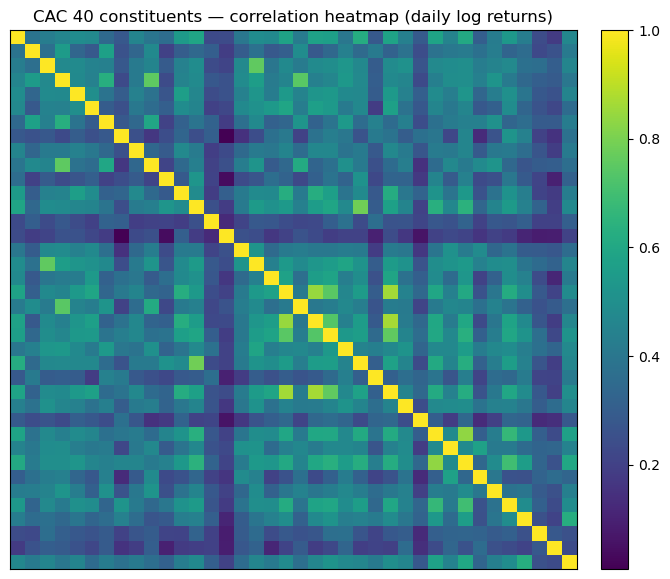

In [9]:
def corr_heatmap(df: pd.DataFrame, title='Correlation heatmap'):
    C = df.corr().to_numpy()
    plt.figure(figsize=(8, 7))
    im = plt.imshow(C, interpolation='nearest', aspect='auto')
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()

corr_heatmap(rets, title='CAC 40 constituents — correlation heatmap (daily log returns)')

## 3) Sample covariance diagnostics

Diagnostics:
- **Eigenvalue spectrum** of the covariance matrix
- **Condition number** $\kappa(\Sigma)=\lambda_{\max}/\lambda_{\min}$

**Task:** Implement `sample_cov` and `condition_number`.


In [10]:
def sample_cov(X: np.ndarray):
    """Return the sample covariance matrix of X with shape (T, N)."""
    X_centered = X - np.mean(X, axis=0)
    T = X.shape[0]
    cov_matrix = (X_centered.T @ X_centered) / (T - 1)
    return cov_matrix

def condition_number(S: np.ndarray):
    """Return the condition number using eigenvalues (protect against tiny eigenvalues)."""
    eigenvalues = np.linalg.eigvalsh(S)
    eigenvalues = np.abs(eigenvalues)
    
    # Protect against division by zero or very small eigenvalues
    eps = 1e-10
    max_eig = np.max(eigenvalues)
    
    # Get the minimum POSITIVE eigenvalue
    positive_eigs = eigenvalues[eigenvalues > eps]
    
    if len(positive_eigs) == 0:
        return np.inf  # Matrix is singular
    
    min_eig = np.min(positive_eigs)  # FIX: Use np.min, not np.max!
    
    return max_eig / min_eig

def plot_eigs(S_list, labels, title):
    plt.figure(figsize=(9, 4.5))
    for S, lab in zip(S_list, labels):
        e = np.sort(eigvalsh(S))
        plt.plot(e, label=lab)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel('eigenvalue index (sorted)')
    plt.ylabel('eigenvalue (log scale)')
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.show()


### Compare a short-window sample covariance to a longer-window proxy

A **longer-window sample covariance** can be used as a *stability proxy* (more data → less estimation noise, but potentially more stale).

**Task:** Run the cell after implementing the functions.


Condition number (reference proxy): 166.85925997453987
Condition number (window sample):   313.5890977513905


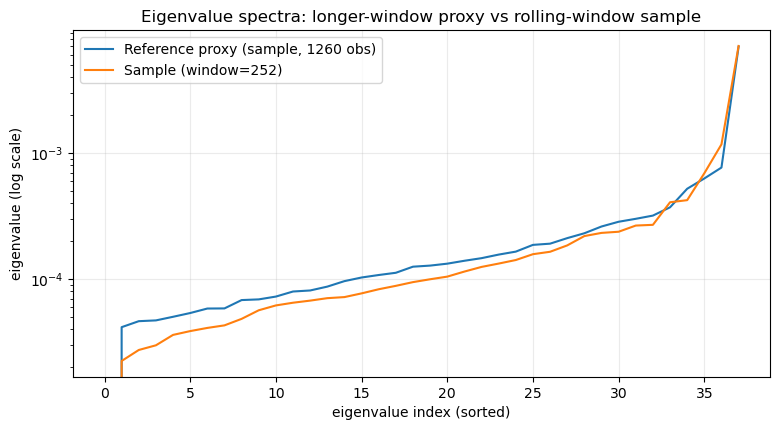

In [11]:
window = 252  # 1Y
Xw = rets.iloc[:window].to_numpy()

S_win = sample_cov(Xw)
ref_len = min(len(rets), 5 * 252)
S_ref = sample_cov(rets.iloc[:ref_len].to_numpy())

print('Condition number (reference proxy):', condition_number(S_ref))
print('Condition number (window sample):  ', condition_number(S_win))

plot_eigs(
    [S_ref, S_win],
    [f'Reference proxy (sample, {ref_len} obs)', f'Sample (window={window})'],
    'Eigenvalue spectra: longer-window proxy vs rolling-window sample'
)

## 4) Minimum-variance portfolio (long-only)

Long-only minimum-variance portfolio:
$$
\min_w\; w^\top \hat\Sigma w\quad\text{s.t.}\quad \sum_i w_i=1,\; 0\le w_i\le 1.
$$

**Tasks:** Implement `min_var_weights` and `herfindahl`, then compare weights computed from `S_win` vs `S_ref`.


Herfindahl (reference proxy weights): 0.2618209024272214
Herfindahl (window sample weights):   0.2785598449949995


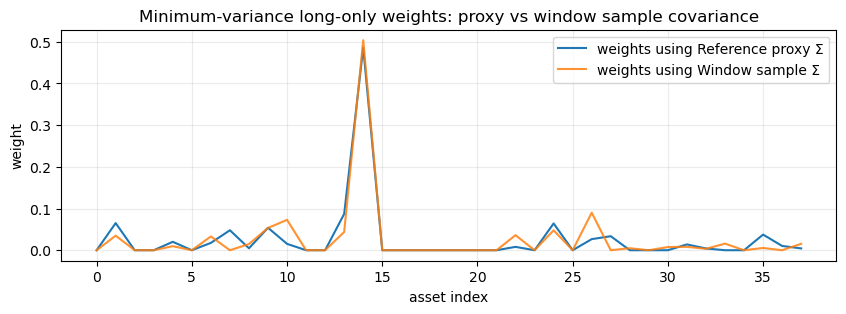

In [12]:
def min_var_weights(S: np.ndarray, ridge=1e-4):
    """Long-only min-variance weights with sum(w)=1 using SLSQP."""
    
    N = S.shape[0]
    S_reg = S + ridge * np.eye(N)
    
    # DEBUG: Check the covariance matrix
    #print(f"Cov matrix shape: {S.shape}")
    #print(f"Cov matrix condition number: {condition_number(S)}")
    #print(f"Ridge-adjusted condition number: {condition_number(S_reg)}")
    
    def objective(w):
        return w.T @ S_reg @ w
    
    def gradient(w):
        return 2 * S_reg @ w
    
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 1) for _ in range(N)]
    w0 = np.ones(N) / N
    
    # DEBUG: Check initial state
    # print(f"Initial objective value: {objective(w0)}")
    
    result = minimize(
        objective,
        w0,
        method='SLSQP',
        jac=gradient,
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 1000, 'ftol': 1e-9}
    )
    
    # DEBUG: Check result
    #print(f"Optimization success: {result.success}")
    #print(f"Optimization message: {result.message}")
    #print(f"Final objective value: {result.fun}")
    #print(f"Objective reduction: {objective(w0) - result.fun}")
    #print(f"Weights changed: {not np.allclose(result.x, w0)}")
    #print(f"Weight range: [{result.x.min():.6f}, {result.x.max():.6f}]")
    #print()
    
    return result.x

def herfindahl(w: np.ndarray):
    """Herfindahl index H = sum_i w_i^2 (concentration)."""
    return np.sum(w**2)

w_win = min_var_weights(S_win)
w_ref = min_var_weights(S_ref)

print('Herfindahl (reference proxy weights):', herfindahl(w_ref))
print('Herfindahl (window sample weights):  ', herfindahl(w_win))

plt.figure(figsize=(10, 3))
plt.plot(w_ref, label='weights using Reference proxy Σ')
plt.plot(w_win, label='weights using Window sample Σ', alpha=0.85)
plt.title('Minimum-variance long-only weights: proxy vs window sample covariance')
plt.xlabel('asset index')
plt.ylabel('weight')
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()


## 5) Regularized covariance estimators

Implement and compare:
- Sample covariance (baseline)
- **Ledoit–Wolf** shrinkage
- **OAS** shrinkage
- **PCA factor covariance** (low rank + diagonal)

Graphical Lasso is optional and may require careful preprocessing.


In [13]:
def cov_ledoit_wolf(X: np.ndarray):
    return LedoitWolf().fit(X).covariance_

def cov_oas(X: np.ndarray):
    return OAS().fit(X).covariance_

def cov_pca_factor(X: np.ndarray, n_factors=5):
    """Return PCA/factor covariance: U Λ U^T + diag(residual var)."""
    pca = PCA(n_components=n_factors)
    pca.fit(X)

    U = pca.components_.T
    Lambda = np.diag(pca.explained_variance_)

    factor_cov = U @ Lambda @ U.T

    total_var = np.var(X, axis=0, ddof=1)
    explained_var = np.diag(factor_cov)
    residual_var = np.maximum(total_var - explained_var, 0)

    cov_matrix = factor_cov + np.diag(residual_var)
    return cov_matrix

def cov_graph_lasso_optional(X: np.ndarray, alpha=0.05):
    """Optional: try Graphical Lasso on standardized (and clipped) data."""
    X_std = (X - np.mean(X, axis=0)) / np.std(X, axis=0, ddof=1)
    
    # Clip extreme values to reduce outlier influence
    X_clipped = np.clip(X_std, -3, 3)
    
    # Fit Graphical Lasso
    try:
        gl = GraphicalLasso(alpha=alpha, max_iter=100)
        gl.fit(X_clipped)
        
        # Return covariance matrix (rescaled back to original scale)
        std_devs = np.std(X, axis=0, ddof=1)
        cov_matrix = gl.covariance_ * np.outer(std_devs, std_devs)
        
        return cov_matrix
    except:
        # If GraphicalLasso fails to converge, fall back to sample covariance
        return np.cov(X, rowvar=False)


### Single-window comparison: conditioning and eigen spectra

**Task:** Run after implementing the estimators. Which estimators improve conditioning?


Sample              cond=    163.99
LedoitWolf          cond=     75.76
OAS                 cond=     99.88
PCA factor(k=5)     cond=     68.59


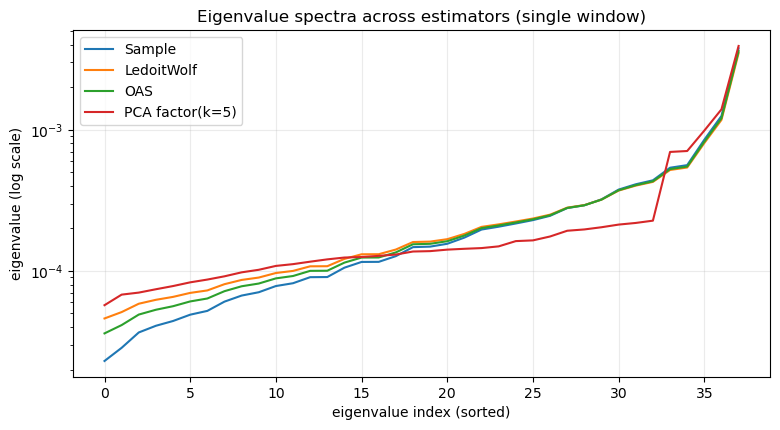

In [14]:
Xw = rets.iloc[-window:].to_numpy()

S_dict = {
    'Sample': sample_cov(Xw),
    'LedoitWolf': cov_ledoit_wolf(Xw),
    'OAS': cov_oas(Xw),
    'PCA factor(k=5)': cov_pca_factor(Xw, n_factors=5),
}

for k, S in S_dict.items():
    print(f'{k:18s}  cond={condition_number(S):10.2f}')

plot_eigs(list(S_dict.values()), list(S_dict.keys()),
          'Eigenvalue spectra across estimators (single window)')


## 6) Rolling allocation experiment (out-of-sample evaluation)

Rolling procedure:
1. Fit $\hat\Sigma_t$ on trailing `window`
2. Compute long-only min-variance weights
3. Hold for `hold` days
4. Evaluate realized volatility, turnover, concentration

**Tasks:** Implement `turnover` and `rolling_backtest_minvar`.


In [15]:
def turnover(w_prev: np.ndarray, w_new: np.ndarray):
    """0.5 * L1 turnover."""
    return 0.5 * np.sum(np.abs(w_new - w_prev))

def rolling_backtest_minvar(rets: pd.DataFrame, window=252, hold=21, estimator='sample', pca_k=5):
    """Return a DataFrame with turnover & herfindahl per rebalance + attrs with summary stats."""
    X = rets.to_numpy()
    T, N = X.shape

    def fit_cov(Xw):
        if estimator == 'sample':
            return sample_cov(Xw)
        if estimator == 'lw':
            return cov_ledoit_wolf(Xw)
        if estimator == 'oas':
            return cov_oas(Xw)
        if estimator == 'gl':
            return cov_graph_lasso_optional(Xw, alpha=0.05)
        if estimator == 'pca':
            return cov_pca_factor(Xw, n_factors=pca_k)
        raise ValueError('unknown estimator')

    weights = []
    dates_w = []
    realized = []
    turns = []
    conc = []
    neff = []
    w_prev = np.ones(N) / N
    # Add these print statements inside your loop to debug:
    for t in range(T - 4*window, T - hold, hold):
        Xw = X[t - window:t]
        S = fit_cov(Xw)
        w = min_var_weights(S)
        
        # DEBUG: Print to see what's happening
        #print(f"Iteration {len(weights)}")
        #print(f"w_prev: {w_prev[:5]}")  # First 5 weights
        #print(f"w_new:  {w[:5]}")
        #print(f"Turnover: {turnover(w_prev, w)}")
        #print(f"Are they identical? {np.allclose(w_prev, w)}")
        #print()
        
        r_next = X[t:t + hold] @ w
        realized.append(r_next)
        
        turns.append(turnover(w_prev, w))
        conc.append(herfindahl(w))
        neff.append(1.0 / herfindahl(w))
        
        w_prev = w.copy()
        
        weights.append(w)
        dates_w.append(rets.index[t])

    realized = np.concatenate(realized)
    out = pd.DataFrame({'turnover': turns, 'herfindahl': conc,'neff':neff},
                       index=pd.Index(dates_w, name='date'))

    out.attrs['realized_vol'] = float(np.std(realized, ddof=1) * np.sqrt(252))
    out.attrs['mean_return']  = float(np.mean(realized) * 252)
    out.attrs['sharpe']       = float(out.attrs['mean_return'] / (out.attrs['realized_vol'] + 1e-12))
    out.attrs['realized_returns'] = realized
    out.attrs['weights'] = np.vstack(weights)
    return out



### Run the rolling comparison

**Task:** Run and interpret. Do regularized estimators reduce turnover? Do they reduce realized volatility?


In [16]:
estimators = {
    'Sample':     dict(estimator='sample'),
    'LedoitWolf': dict(estimator='lw'),
    'OAS':        dict(estimator='oas'),
    'PCA factor': dict(estimator='pca', pca_k=5),
}

results = {name: rolling_backtest_minvar(rets, window=252, hold=21, **kwargs)
           for name, kwargs in estimators.items()}

summary = pd.DataFrame({
    'Realized vol (ann.)': {k: v.attrs['realized_vol'] for k, v in results.items()},
    'Mean return (ann.)':  {k: v.attrs['mean_return'] for k, v in results.items()},
    'Sharpe (ann.)':       {k: v.attrs['sharpe'] for k, v in results.items()},
    'Avg turnover':        {k: float(v['turnover'].mean()) for k, v in results.items()},
    'Avg Herfindahl':      {k: float(v['herfindahl'].mean()) for k, v in results.items()},
}).sort_values('Realized vol (ann.)')

summary


,Realized vol (ann.),Mean return (ann.),Sharpe (ann.),Avg turnover,Avg Herfindahl
PCA factor,0.107411,0.080626,0.750631,0.103362,0.100408
Sample,0.108052,0.078379,0.725384,0.095159,0.092386
OAS,0.108257,0.077304,0.714075,0.091173,0.089534
LedoitWolf,0.108409,0.076653,0.707072,0.089708,0.087227


### Visualize trade-offs

**Task:** Run the plots and summarize the main lessons.


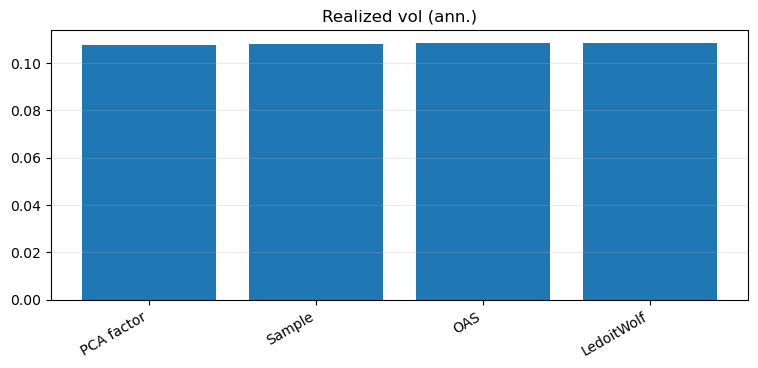

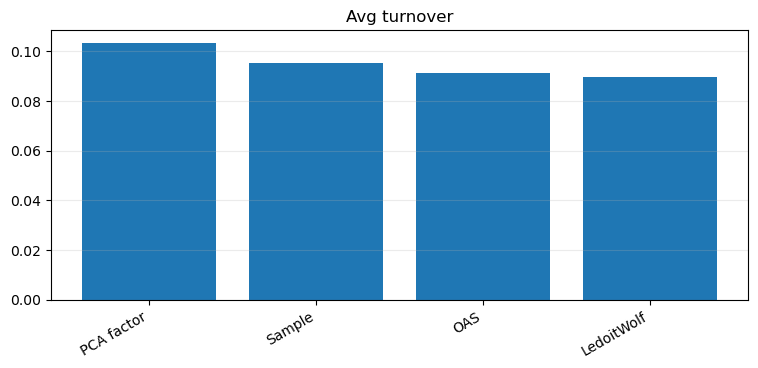

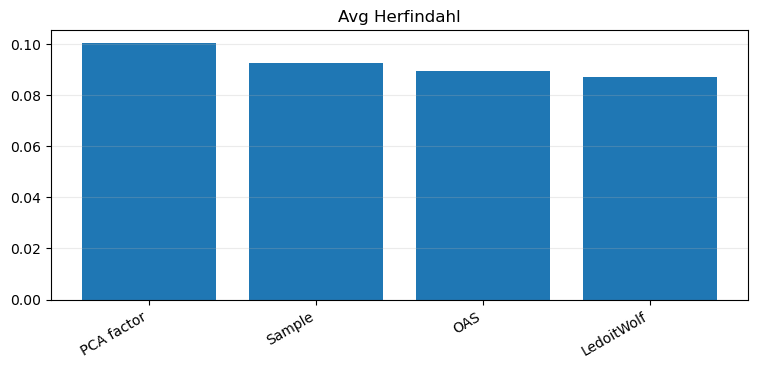

In [17]:
metrics = ['Realized vol (ann.)', 'Avg turnover', 'Avg Herfindahl']
for m in metrics:
    plt.figure(figsize=(9, 3.5))
    plt.bar(summary.index, summary[m].values)
    plt.title(m)
    plt.xticks(rotation=30, ha='right')
    plt.grid(True, axis='y', alpha=0.25)
    plt.show()


## 7) Extension questions (optional)

1. Try `window=126` (6 months). Which estimator becomes most useful? Why?
2. Change `pca_k` (e.g., 2, 5, 10). What happens to stability and realized vol?
3. Add a simple turnover penalty to the optimization objective.
4. Implement an eigenvalue-clipping (RMT-style) denoiser.
